![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
# Importación de librerías

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
# Liberias para modelos

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1

# Se toma la decisión de tener árboles solo con 3 nodos o 2 divisiones

# Función para dividir los datos en dos ramas según un umbral
def div_data(X, y, feature, threshold):
    left_mask = X[feature] <= threshold
    right_mask = X[feature] > threshold
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

# Función para encontrar la mejor división con base en MSE
def find_best_split(X, y, min_samples_leaf=5):
    best_feature, best_threshold, best_mse = None, None, float('inf')
    
    for feature in X.columns:
        for threshold in X[feature].unique():
            X_left, X_right, y_left, y_right = div_data(X, y, feature, threshold)
            if len(y_left) < min_samples_leaf or len(y_right) < min_samples_leaf:
                continue  # Evita divisiones con hojas demasiado pequeñas

            mse = (len(y_left) * mean_squared_error(y_left, np.mean(y_left)) +
                   len(y_right) * mean_squared_error(y_right, np.mean(y_right))) / len(y)

            if mse < best_mse:
                best_feature, best_threshold, best_mse = feature, threshold, mse

    return best_feature, best_threshold

# Función de error cuadrático medio (MSE)
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Función de raíz del error cuadrático medio (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Función de error absoluto medio (MAE)
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Cálculo manual de R²
def r2_score_manual(y_true, y_pred):
    sse = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (sse / sst)

# Función para entrenar un árbol de decisión con dos divisiones
def train_manual_tree(X_train, y_train):
    # Primera división
    best_feature1, best_threshold1 = find_best_split(X_train, y_train)
    X_left1, X_right1, y_left1, y_right1 = div_data(X_train, y_train, best_feature1, best_threshold1)

    # Segunda división en cada rama
    best_feature2_left, best_threshold2_left = find_best_split(X_left1, y_left1)
    X_left2, X_right2, y_left2, y_right2 = div_data(X_left1, y_left1, best_feature2_left, best_threshold2_left)

    best_feature2_right, best_threshold2_right = find_best_split(X_right1, y_right1)
    X_left3, X_right3, y_left3, y_right3 = div_data(X_right1, y_right1, best_feature2_right, best_threshold2_right)

    # Cálculo de valores promedio en las hojas
    leaf_left2, leaf_right2 = np.mean(y_left2), np.mean(y_right2)
    leaf_left3, leaf_right3 = np.mean(y_left3), np.mean(y_right3)

    return {
        "best_feature1": best_feature1, "best_threshold1": best_threshold1,
        "best_feature2_left": best_feature2_left, "best_threshold2_left": best_threshold2_left,
        "best_feature2_right": best_feature2_right, "best_threshold2_right": best_threshold2_right,
        "leaf_left2": leaf_left2, "leaf_right2": leaf_right2,
        "leaf_left3": leaf_left3, "leaf_right3": leaf_right3
    }

# Función de predicción con el árbol entrenado
def predict_manual_tree(X, tree):
    y_pred = np.zeros(len(X))
    mask1 = X.loc[:, tree["best_feature1"]] <= tree["best_threshold1"]
    mask2_left = X.loc[:, tree["best_feature2_left"]] <= tree["best_threshold2_left"]
    mask2_right = X.loc[:, tree["best_feature2_right"]] <= tree["best_threshold2_right"]
    y_pred[mask1 & mask2_left] = tree["leaf_left2"]
    y_pred[mask1 & ~mask2_left] = tree["leaf_right2"]
    y_pred[~mask1 & mask2_right] = tree["leaf_left3"]
    y_pred[~mask1 & ~mask2_right] = tree["leaf_right3"]

    return y_pred

# Entrenar el árbol de decisión
tree = train_manual_tree(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_f_manual = predict_manual_tree(X_test, tree)

# Evaluación y resultados del modelo
rmse_f_manual = root_mean_squared_error(y_test, y_pred_f_manual)
mae_f_manual = mean_absolute_error(y_test, y_pred_f_manual)
r2_f_manual = r2_score_manual(y_test, y_pred_f_manual)

print(f"División 1: {tree['best_feature1']} ≤ {tree['best_threshold1']}")
print(f"División 2 (izq): {tree['best_feature2_left']} ≤ {tree['best_threshold2_left']}")
print(f"División 2 (der): {tree['best_feature2_right']} ≤ {tree['best_threshold2_right']}")
print(f"RMSE: {rmse_f_manual:.4f} | MAE: {mae_f_manual:.4f} | R²: {r2_f_manual:.4f}")

División 1: Year ≤ 2012
División 2 (izq): Year ≤ 2011
División 2 (der): Year ≤ 2016
RMSE: 2174.8814 | MAE: 1671.6008 | R²: 0.6908


In [9]:
y.describe()

count    10495.000000
mean     14538.403716
std       3922.420961
min       5002.000000
25%      11999.000000
50%      15000.000000
75%      16999.000000
max      32444.000000
Name: Price, dtype: float64

**Análisis**

Se identifica que la mejor variable para dividir los datos es "Year", que representa el modelo del automóvil. En las tres divisiones realizadas, todas tomaron como referencia esta variable, lo que sugiere que el año de fabricación influye significativamente en el precio. Las divisiones ocurrieron en los años 2012, 2011 y 2016, lo que podría estar relacionado con cambios tecnológicos o modificaciones en los vehículos en esas fechas.

El error cuadrático medio (RMSE) es aproximadamente 2175, lo que indica que, en promedio, la predicción difiere del valor real en esa cantidad. Comparado con la desviación estándar del precio, que es de 3922, el error es menor, lo que sugiere que el modelo logra una buena aproximación. 

El error absoluto medio (MAE) obtenido es aproximadamente $1672. Esto indica que, en promedio, el modelo se equivoca en esa cantidad cuando predice el precio de un automóvil. Dado que el MAE es una métrica que mide el error sin penalizar los valores atípicos como el RMSE, se puede decir que el modelo tiene un desempeño estable con opciones de mejora.

El coeficiente de determinación (R²) es de 0.69, lo que implica que el 69% de la variabilidad en los precios puede explicarse por la segmentación realizada según el año del modelo. Aún queda un 31% de la variación sin explicar, lo que indica que hay otros factores influyendo en el precio que no han sido considerados en esta división.


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [10]:
# Celda 2

# Función para crear subconjuntos con bootstrap
def bootstrap_sample(X, y, size=None):
    if size is None:
        size = len(X)
    indices = np.random.choice(len(X), size=size, replace=True)
    print(indices)
    return X.iloc[indices].copy(), y.iloc[indices].copy()

# Función para entrenar múltiples árboles utilizando la función del Punto 1
def train_bagging_trees(X_train, y_train, num_trees=None):
    trees = []
    for _ in range(num_trees):
        X_sample, y_sample = bootstrap_sample(X_train, y_train)  # Bootstrap sampling
        tree = train_manual_tree(X_sample, y_sample)  # Entrenar usando la función del Punto 1
        trees.append(tree)
        print(f"Árbol {_+1}: {tree}")
    return trees

# Función para hacer predicciones con Bagging
def bagging_predict(X_test, trees):
    preds = np.array([predict_manual_tree(X_test, tree) for tree in trees])  # Predicciones de cada árbol
    return np.mean(preds, axis=0)  # Promedio de predicciones

# Entrenar el modelo con 10 árboles
trees = train_bagging_trees(X_train, y_train, num_trees=10)
tree_test = trees[0]
print(tree_test)

# Evaluación y resultados del modelo
y_pred_bagging = bagging_predict(X_test, trees)

rmse_bagging = root_mean_squared_error(y_test, y_pred_bagging)
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)
r2_bagging = r2_score_manual(y_test, y_pred_bagging)

print(f"Bagging - RMSE: {rmse_bagging:.4f} | MAE: {mae_bagging:.4f} | R²: {r2_bagging:.4f}")

[5741 6422 4634 ... 4754  564 3560]
Árbol 1: {'best_feature1': 'Year', 'best_threshold1': 2011, 'best_feature2_left': 'Mileage', 'best_threshold2_left': 119067, 'best_feature2_right': 'Mileage', 'best_threshold2_right': 46494, 'leaf_left2': 9538.218199608611, 'leaf_right2': 7142.976034858388, 'leaf_left3': 16901.764485514486, 'leaf_right3': 13671.415912031049}
[2299  407 5369 ... 2574 6409 2804]
Árbol 2: {'best_feature1': 'Year', 'best_threshold1': 2013, 'best_feature2_left': 'Year', 'best_threshold2_left': 2011, 'best_feature2_right': 'Year', 'best_threshold2_right': 2016, 'leaf_left2': 8758.757617728532, 'leaf_right2': 12884.04391468005, 'leaf_left3': 15961.497832185667, 'leaf_right3': 19281.878020713462}
[2328 6036  168 ... 5165 4394 1358]
Árbol 3: {'best_feature1': 'Year', 'best_threshold1': 2012, 'best_feature2_left': 'Year', 'best_threshold2_left': 2010, 'best_feature2_right': 'Mileage', 'best_threshold2_right': 27926, 'leaf_left2': 8185.4480220791165, 'leaf_right2': 11696.101995

**Análisis**

En el Punto 1 se identificó que la variable clave para dividir los datos era "Year", con cortes en 2012, 2011 y 2016, lo que resultó en un RMSE de 2175, MAE de 1672 y un R² de 0.69. Al aplicar Bagging en el Punto 2, se entrenaron múltiples árboles sobre muestras bootstrap del conjunto de entrenamiento, y al promediar sus predicciones se obtuvo un RMSE de 2002.80, MAE de 1489.32 y un R² de 0.7378. 

Esto indica que el modelo combinado tiene un error promedio menor y explica un mayor porcentaje de la variabilidad en los precios (73.78% en lugar de 69%), demostrando que Bagging mejora la estabilidad y precisión del modelo al reducir la varianza y suavizar errores individuales.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [11]:
# Celda 3

# Calculo de max_features
n_features = X_train.shape[1]
max_features = int(np.log(n_features))

# Modelo de Bagging usando sklearn
bagging_model_sk = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features= max_features,
    random_state=42
)
bagging_model_sk.fit(X_train, y_train) # Entrenamiento del modelo

# Evaluación y métricas del modelo
y_pred_bagging_sk = bagging_model_sk.predict(X_test)
rmse_bagging_sk = root_mean_squared_error(y_test, y_pred_bagging_sk)
mae_bagging_sk = mean_absolute_error(y_test, y_pred_bagging_sk)
r2_bagging_sk = r2_score_manual(y_test, y_pred_bagging_sk)

print(f"Los parámetros del modelo son: n_estimators=10, max_features={max_features}")
print(f"Bagging - RMSE: {rmse_bagging_sk:.4f} | MAE: {mae_bagging_sk:.4f} | R²: {r2_bagging_sk:.4f}")



# Modelo con max_features=9
bagging_model_9 = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features= 9,
    random_state=42
)
bagging_model_9.fit(X_train, y_train)
y_pred_bagging = bagging_model_9.predict(X_test)
rmse_bagging_9 = root_mean_squared_error(y_test, y_pred_bagging)
mae_bagging_9 = mean_absolute_error(y_test, y_pred_bagging)
r2_bagging_9 = r2_score_manual(y_test, y_pred_bagging)
print(f"Los parámetros del modelo son: n_estimators=10, max_features=9")
print(f"Bagging - RMSE: {rmse_bagging_9:.4f} | MAE: {mae_bagging_9:.4f} | R²: {r2_bagging_9:.4f}")


Los parámetros del modelo son: n_estimators=10, max_features=2
Bagging - RMSE: 2768.3504 | MAE: 2160.7620 | R²: 0.4990
Los parámetros del modelo son: n_estimators=10, max_features=9
Bagging - RMSE: 1792.2818 | MAE: 1335.8180 | R²: 0.7900


**Análisis**

El modelo Bagging con sklearn mostró un desempeño inferior al modelo manual del punto 2, como se observa en las siguientes métricas:
* RMSE = 2768, lo que significa que, en promedio, la predicción se desvía en esta cantidad del valor real. Es menos preciso que el modelo manual, que obtuvo un RMSE de 2002.
* MAE = 2160, lo que indica que el error absoluto promedio por predicción es mayor que en el modelo manual (MAE = 1489), lo que significa que este modelo se equivoca más en cada estimación.
* R² = 0.499, lo que implica que solo el 50% de la variabilidad en el precio de los carros se explica con este modelo. Comparado con el 0.7378 del modelo manual, la diferencia es considerable.

En general, este Bagging no presenta mejoras respecto al modelo del punto 2, esto puede estar relacionado con la configuración de los parámetros, especialmente con max_features. En el punto 2, se usaron todas las características disponibles, mientras que en este modelo, max_features se calculó como log(n_features) (resultando 2), reduciendo la cantidad de información usada en cada estimador.

Para verificar este impacto, se hizo una prueba aumentando max_features a 9 (todas las características disponibles) y se observó una mejora significativa, logrando incluso superar el desempeño del modelo manual. Esto confirma que la selección de características en cada estimador es muy importante para el rendimiento del modelo y que la librería se encuentra optimizada para obtener las mejores métricas.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [12]:
# Celda 4

# Se tomaron los parámetros de Random Forest por defecto (100 árboles y max_features=None)
rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

# Evaluación y métricas del modelo
y_pred_rf = rf_model.predict(X_test)

rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score_manual(y_test, y_pred_rf)

print("Se tomaron los parámetros del modelo por defecto: n_estimators=100, max_features=None")
print(f"Random Forest - RMSE: {rmse_rf:.4f} | MAE: {mae_rf:.4f} | R²: {r2_rf:.4f}\n")


# Se tomaron los parámetros del modelo con bagging del punto 3, esto para poder realizar la comparación con el modelo de Random Forest
rf_model = RandomForestRegressor(
    n_estimators=10,
    max_features= max_features,
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score_manual(y_test, y_pred_rf)
print(f"Se tomaron los parámetros del modelo: n_estimators=10, max_features={max_features}")
print(f"Random Forest - RMSE: {rmse_rf:.4f} | MAE: {mae_rf:.4f} | R²: {r2_rf:.4f}")

Se tomaron los parámetros del modelo por defecto: n_estimators=100, max_features=None
Random Forest - RMSE: 1759.2765 | MAE: 1308.9377 | R²: 0.7977

Se tomaron los parámetros del modelo: n_estimators=10, max_features=2
Random Forest - RMSE: 1816.0864 | MAE: 1356.8759 | R²: 0.7844


**Análisis**

El modelo con los parámetros por defecto (100 árboles y todas las características) tuvo mejor desempeño porque al usar más estimadores se reduce la variabilidad en las predicciones. Además, al permitir que cada división del árbol evalúe todas las características, el modelo tiene más información para tomar mejores decisiones.

En cambio, cuando se usaron solo 10 árboles y se limitaron las características a 2 por división, el modelo perdió estabilidad, lo que hizo que las predicciones fueran menos precisas y más sensibles a los datos específicos del entrenamiento. Esto muestra que, aunque Random Forest es un modelo fuerte, la configuración de los parámetros juega un papel clave en su rendimiento.

AHora, comparando el modelo de Random Forest con sklearn respecto a los modelos anteriores, se obteniene:
* RMSE: 1816.09. En promedio, el error de la predicción es menor que en los modelos anteriores. Comparado con el modelo manual (2002) y el Bagging (2768), este modelo predice con más precisión.
* MAE: 1356.88. El error absoluto medio es menor que en los otros casos. Comparado con el modelo manual (1489) y el Bagging (2160), indica que las predicciones están más cerca de los valores reales.
* R²: 0.7844. Explica el 78.4% de la variabilidad del precio de los carros, mejorando bastante respecto a Bagging (49.9%) y el modelo manual (73.8%).

En general, este modelo en este paquede de datos funciona mejor cuando aprovecha todas las características que se tienen.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [13]:
# Celda 5

# Evaluación de Random Forest con diferentes valores de n_estimators, usando cross validation
estimator_range = range(10, 310, 10) # Rango de valores para n_estimators
mse_scores_estimators = []
mae_scores_estimators = []
r2_scores_estimators = []
for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    mse = -cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    mae = -cross_val_score(rf, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    r2 = cross_val_score(rf, X, y, cv=5, scoring='r2').mean()
    
    mse_scores_estimators.append(mse)
    mae_scores_estimators.append(mae)
    r2_scores_estimators.append(r2)

In [14]:
# Evaluación de Random Forest con diferentes valores de max_depth, usando cross validation

depth_range = range(2, 22, 2) # Rango de valores para max_depth
mse_scores_depth = []
mae_scores_depth = []
r2_scores_depth = []
for depth in depth_range:
    rf = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=1, n_jobs=-1)
    mse = -cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    mae = -cross_val_score(rf, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    r2 = cross_val_score(rf, X, y, cv=5, scoring='r2').mean()
    
    mse_scores_depth.append(mse)
    mae_scores_depth.append(mae)
    r2_scores_depth.append(r2)


In [15]:
# Evaluación de Random Forest con diferentes valores de max_features, usando cross validation

feature_range = range(max_features, 15, 1) # Rango de valores para max_features
mse_scores_features = []
mae_scores_features = []
r2_scores_features = []
for features in feature_range:
    rf = RandomForestRegressor(n_estimators=100, max_features=features, random_state=1, n_jobs=-1)
    mse = -cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    mae = -cross_val_score(rf, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    r2 = cross_val_score(rf, X, y, cv=5, scoring='r2').mean()
    
    mse_scores_features.append(mse)
    mae_scores_features.append(mae)
    r2_scores_features.append(r2)

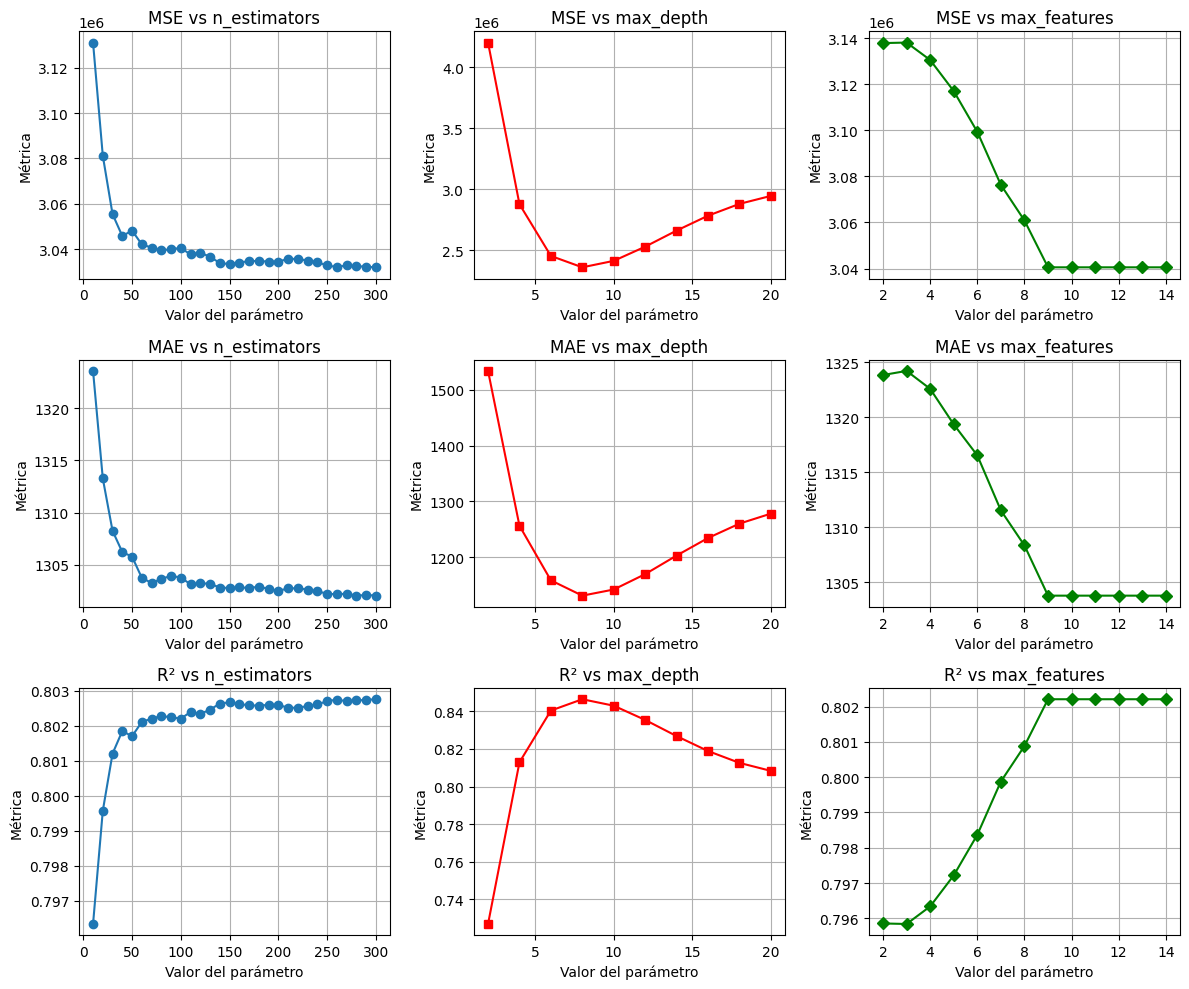

In [16]:
# Gráficas de evaluación de Random Forest con diferentes parámetros
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# Gráficas para n_estimators
axes[0, 0].plot(estimator_range, mse_scores_estimators, marker='o', linestyle='-')
axes[0, 0].set_title("MSE vs n_estimators")
axes[1, 0].plot(estimator_range, mae_scores_estimators, marker='o', linestyle='-')
axes[1, 0].set_title("MAE vs n_estimators")
axes[2, 0].plot(estimator_range, r2_scores_estimators, marker='o', linestyle='-')
axes[2, 0].set_title("R² vs n_estimators")

# Gráficas para max_depth
axes[0, 1].plot(depth_range, mse_scores_depth, marker='s', linestyle='-', color='r')
axes[0, 1].set_title("MSE vs max_depth")
axes[1, 1].plot(depth_range, mae_scores_depth, marker='s', linestyle='-', color='r')
axes[1, 1].set_title("MAE vs max_depth")
axes[2, 1].plot(depth_range, r2_scores_depth, marker='s', linestyle='-', color='r')
axes[2, 1].set_title("R² vs max_depth")

# Gráficas para max_features
axes[0, 2].plot(feature_range, mse_scores_features, marker='D', linestyle='-', color='g')
axes[0, 2].set_title("MSE vs max_features")
axes[1, 2].plot(feature_range, mae_scores_features, marker='D', linestyle='-', color='g')
axes[1, 2].set_title("MAE vs max_features")
axes[2, 2].plot(feature_range, r2_scores_features, marker='D', linestyle='-', color='g')
axes[2, 2].set_title("R² vs max_features")

# Etiquetas generales
for ax in axes.flat:
    ax.set_xlabel("Valor del parámetro")
    ax.set_ylabel("Métrica")
    ax.grid()

plt.tight_layout()
plt.show()


**Análisis**

Se analizará cada parámetro por separado:
* **n_stimators:**

    Este parámetro nos habla del número de árboles que tendrá el modelo.

    El MSE y MAE bajan rápidamente mientras se incrementa el número de árboles, encontrando en 150 aproximadamente algo de estabilidad y reducciones muy bajas.

    El R2 mejora rápidamente al inicio, se estabiliza de igual manera en 150 árboles y llegando a explicar más del 80% de la variabilidad de la variable de respuesta.

    Un buen valor de árboles estaría al rededor de 150, ya que incrementarlos más allá de este valor no mejoraría significativamente los resultados de las métricas. 

* **max_depth:**

    Este parámetro nos habla del crecimiento del árbol.

    Al igual que en el caso anterior, se encuentra un valor óptimo en donde se minimizan los errores y se maximiza la explicación de la variación. Este valor estaría cercano a 8.

    Un valor muy alto de este parámetro, hace que el modelo prácticamente memorice los datos y para predecir no sea bueno.

* **max_features:**

    Este parámetro es el número de variables que el modelo usara en cada división del árbol.

    En este caso en específico, se puede observar que al tener todas las variables en ecuenta (9) se obtienen los valores mínimos para el error y máximos para la explicación del modelo.

    Tener todas las varibales, puede presentar sobreajuste del modelo y que memorice los datos.

Este análisis es muy valioso para poder encontrar los mejores parámetros del modelo. A continuación se correrá el modelo con los mejores parámetros encontrados.

In [17]:
rf_model_mejor = RandomForestRegressor(
    n_estimators=150,
    max_depth=8,
    max_features=9,
    random_state=42
)
rf_model_mejor.fit(X_train, y_train)
y_pred_rf_mejor = rf_model_mejor.predict(X_test)
rmse_rf_mejor = root_mean_squared_error(y_test, y_pred_rf_mejor)
mae_rf_mejor = mean_absolute_error(y_test, y_pred_rf_mejor)
r2_rf_mejor = r2_score_manual(y_test, y_pred_rf_mejor)
print("Se tomaron los mejore parámetros encontrados con el análisis anterior: n_estimators=150, max_depth=8, max_features=9")
print(f"Random Forest - RMSE: {rmse_rf_mejor:.4f} | MAE: {mae_rf_mejor:.4f} | R²: {r2_rf_mejor:.4f}")

Se tomaron los mejore parámetros encontrados con el análisis anterior: n_estimators=150, max_depth=8, max_features=9
Random Forest - RMSE: 1564.7282 | MAE: 1150.2656 | R²: 0.8399


El modelo final con `n_estimators` = 150, `max_depth` = 8 y `max_features` = 9 alcanzó un R² de 0.8399, lo que indica una buena capacidad de predicción. El RMSE de 1564.72 y el MAE de 1150.27 muestran errores relativamente bajos en comparación de los modelos anteriores.

La elección de estos parámetros permite un buen equilibrio entre complejidad y generalización, evitando sobreajuste y mejorando la estabilidad del modelo. Aún se podría probar reduciendo `max_features` para evaluar si algunas variables no aportan valor o aumentando `n_estimators` para verificar si hay mejoras sin mayor costo computacional.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [18]:
# Celda 6

# Definición de modelo con parámetros por defecto
model = xgb.XGBRegressor()

# Evaluación y métricas del modelo
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse_xgb = root_mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score_manual(y_test, y_pred)

print("Se tomaron los parámetros por defecto para XGBoost: learning_rate=0.1, gamma=0, colsample_bytree=1.0")
print(f"XGBoost - RMSE: {rmse_xgb:.4f} | MAE: {mae_xgb:.4f} | R²: {r2_xgb:.4f}")

Se tomaron los parámetros por defecto para XGBoost: learning_rate=0.1, gamma=0, colsample_bytree=1.0
XGBoost - RMSE: 1605.2355 | MAE: 1185.2273 | R²: 0.8315


El modelo XGBoost con parámetros por defecto mostró desempeño similar al modelo de random forest con parámetros optimizados, llegando a tener RMSE de 1605 y el MAE de 1185, lo que indica una desviación baja y bajo error absoluto en las predicciones. 

Además, el R² se mantiene cercano con 0.8315, lo que sugiere que el modelo explica adecuadamente la variabilidad de los datos. 

Esto indica que, con los datos trabajods, los valores predeterminados de XGBoost ofrecen una configuración efectiva.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [19]:
# Celda 7

# Se hará un proceso similar al punto 5 para el modelo de XGBoost

# Rango de valores para learning_rate
learning_rates = np.arange(0.01, 0.21, 0.01)
results_lr = {'learning_rate': [], 'RMSE': [], 'MAE': [], 'R2': []}
for lr in learning_rates:
    model = xgb.XGBRegressor(learning_rate=lr, random_state=42)
    rmse = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    r2 = cross_val_score(model, X, y, cv=5, scoring='r2').mean()

    # Guardamos los resultados
    results_lr['learning_rate'].append(lr)
    results_lr['RMSE'].append(rmse)
    results_lr['MAE'].append(mae)
    results_lr['R2'].append(r2)


In [20]:
# Rango de valores para gamma
gammas = np.arange(0, 6, 1)
results_gamma = {'gamma': [], 'RMSE': [], 'MAE': [], 'R2': []}
for g in gammas:
    model = xgb.XGBRegressor(gamma=g, random_state=42)
    rmse = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    r2 = cross_val_score(model, X, y, cv=5, scoring='r2').mean()

    results_gamma['gamma'].append(g)
    results_gamma['RMSE'].append(rmse)
    results_gamma['MAE'].append(mae)
    results_gamma['R2'].append(r2)

In [21]:
# Rango de valores para colsample_bytree
colsamples = [i/10 for i in range(1, 11)] 
results_colsample = {'colsample_bytree': [], 'RMSE': [], 'MAE': [], 'R2': []}
for col in colsamples:
    model = xgb.XGBRegressor(colsample_bytree=col, random_state=42)
    rmse = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    r2 = cross_val_score(model, X, y, cv=5, scoring='r2').mean()

    results_colsample['colsample_bytree'].append(col)
    results_colsample['RMSE'].append(rmse)
    results_colsample['MAE'].append(mae)
    results_colsample['R2'].append(r2)

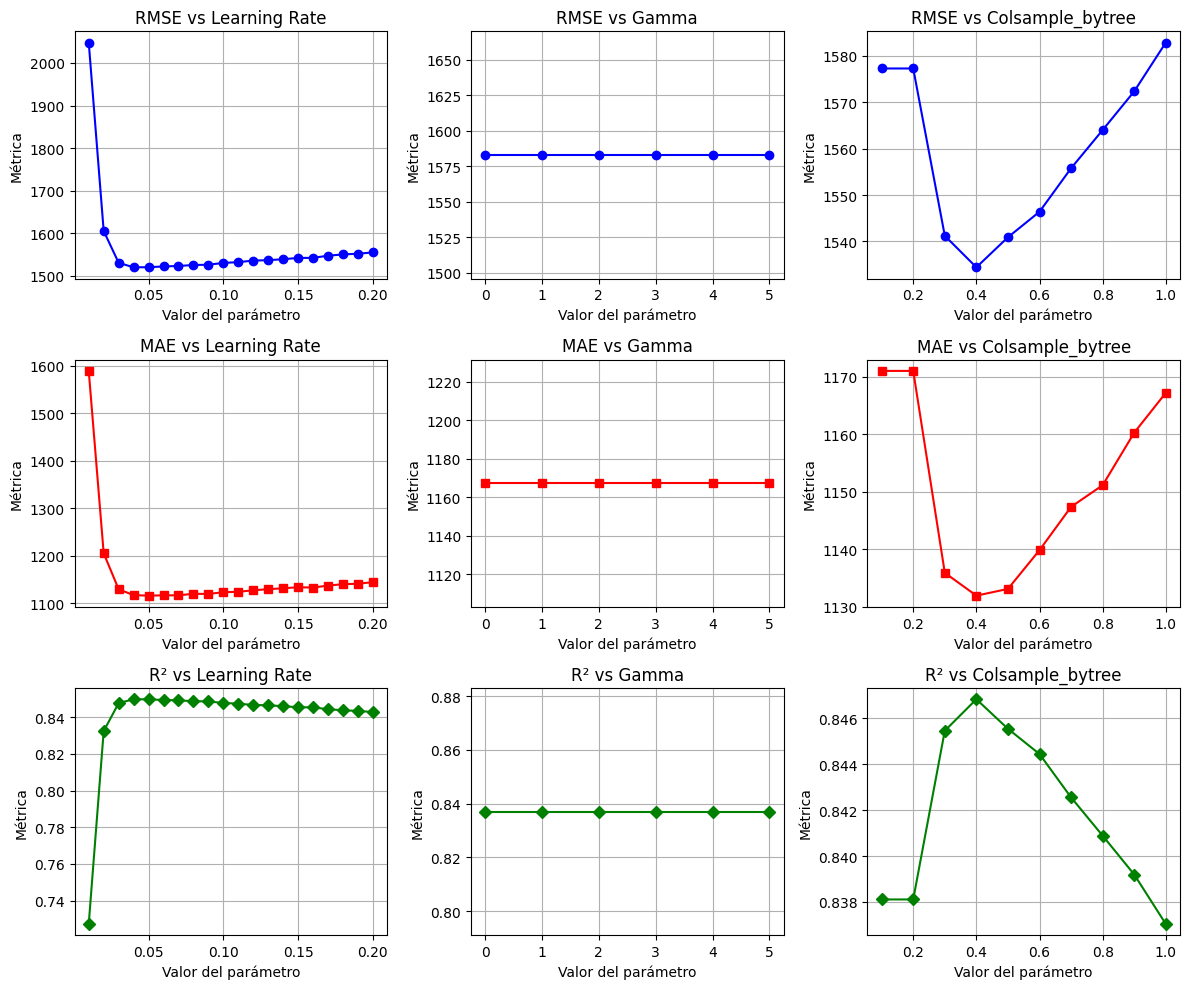

In [22]:
# Gráficas de evaluación de XGBoost con diferentes parámetros
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# Gráficas para learning_rate
axes[0, 0].plot(results_lr['learning_rate'], results_lr['RMSE'], marker='o', linestyle='-', color='b')
axes[0, 0].set_title("RMSE vs Learning Rate")
axes[1, 0].plot(results_lr['learning_rate'], results_lr['MAE'], marker='s', linestyle='-', color='r')
axes[1, 0].set_title("MAE vs Learning Rate")
axes[2, 0].plot(results_lr['learning_rate'], results_lr['R2'], marker='D', linestyle='-', color='g')
axes[2, 0].set_title("R² vs Learning Rate")

# Gráficas para gamma
axes[0, 1].plot(results_gamma['gamma'], results_gamma['RMSE'], marker='o', linestyle='-', color='b')
axes[0, 1].set_title("RMSE vs Gamma")
axes[1, 1].plot(results_gamma['gamma'], results_gamma['MAE'], marker='s', linestyle='-', color='r')
axes[1, 1].set_title("MAE vs Gamma")
axes[2, 1].plot(results_gamma['gamma'], results_gamma['R2'], marker='D', linestyle='-', color='g')
axes[2, 1].set_title("R² vs Gamma")

# Gráficas para colsample_bytree
axes[0, 2].plot(results_colsample['colsample_bytree'], results_colsample['RMSE'], marker='o', linestyle='-', color='b')
axes[0, 2].set_title("RMSE vs Colsample_bytree")
axes[1, 2].plot(results_colsample['colsample_bytree'], results_colsample['MAE'], marker='s', linestyle='-', color='r')
axes[1, 2].set_title("MAE vs Colsample_bytree")
axes[2, 2].plot(results_colsample['colsample_bytree'], results_colsample['R2'], marker='D', linestyle='-', color='g')
axes[2, 2].set_title("R² vs Colsample_bytree")

# Etiquetas y formato
for ax in axes.flat:
    ax.set_xlabel("Valor del parámetro")
    ax.set_ylabel("Métrica")
    ax.grid()

plt.tight_layout()
plt.show()

**Análisis**
El ajuste de hiperparámetros consiste en identificar y seleccionar los hiperparámetros óptimos para el entrenamiento del modelo XGBoosting. En este caso los parámetros a calibrar fueron `learning_rate`, `gamma` y `colsample_bytree`.

* **Learning Rate:**

En términos genrales este parámetro permite definir que tanto contribuye el cada árbol al resultado final, es decir, nos habla de la velocidad de aprendizaje del modelo.

Una tasa de aprendizaje alta significa que un modelo se ajustará más rápidamente, pero con el riesgo de ofrecer un rendimiento inestable y una desviación de los datos. 
Una tasa baja en cambio (menor a 0.02) previene el sobreajuste pero se demora más, requiere más arboles y puede hacer que las métricas de error (RMSE, MSE) incrementen considerablemente.

Un valor de 0.04 sería la mejor entrada para el parámetro.

* **Gamma:**

El valor de gamma corresponde a la reducción de pérdida mínima necesaria para realizar una partición mayor en un nodo de hoja del árbol por lo que controla la complejidad de los árboles, penalizando divisiones poco relevantes.

Con el análisis realizado y los datos trabajados, este parámetro no tiene implicación en los resultados, es decir, este parámetro no ayuda a mejorar la regularización del modelo.

* **Colsample_bytree:**

Este parámetro define la proporción de columna utilizadas en cada árbol. 

Entre más bajo (menor a 0.4) más se reduce el riesgo de sobreajuste mientras que entre más cercano a 1 pueden usarse más variables que pueden ser irrelevantes.

Se encuentra que en 0.6 se puede un mínimo en los errores y un máximo en el ajuste del modelo.

Se concluye que, para `learning rate` el valor optimo sería 0.4, el parámetro `gamma` no tiene implicación en la regularización del modelo, y para `colsame_bytree` debería ser el valor escogido 0.6 para tener el mejor ajuste. Esto se comprobará acontinuación:

In [35]:
# Definir el modelo con los mejores parámetros encontrados
xgb_model_mejor = xgb.XGBRegressor(
    learning_rate=0.04,
    gamma=0,
    colsample_bytree=0.6,
    random_state=42
)

# Entrenar el modelo
xgb_model_mejor.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_xgb_mejor = xgb_model_mejor.predict(X_test)

# Evaluación del modelo
rmse_xgb_mejor = root_mean_squared_error(y_test, y_pred_xgb_mejor)
mae_xgb_mejor = mean_absolute_error(y_test, y_pred_xgb_mejor)
r2_xgb_mejor = r2_score_manual(y_test, y_pred_xgb_mejor)

print("Se tomaron los mejores parámetros encontrados para XGBoost: learning_rate=0.04, gamma=0, colsample_bytree=0.6")
print(f"XGBoost_mejor - RMSE: {rmse_xgb_mejor:.4f} | MAE: {mae_xgb_mejor:.4f} | R²: {r2_xgb_mejor:.4f}")

Se tomaron los mejores parámetros encontrados para XGBoost: learning_rate=0.04, gamma=0, colsample_bytree=0.6
XGBoost_mejor - RMSE: 1552.6087 | MAE: 1144.0925 | R²: 0.8424


Se ajustó un modelo XGBoost con los mejores parámetros encontrados en la calibración: `learning_rate`=0.04, `gamma`=0 y `colsample_bytree` =0.6.

| | XGB sin calibración | XGB con calibraciön |
|:----:|:---------------:|:---------------:|
| MAE| 1185.2273 |1144.0925|
|RMSE|1605.2355 |1552.6087|
|R²|0.8315 |0.8424|

Los resultados muestran un RMSE de 1552, disminuyendo respecto al modelo con parámetros predeterminados. El MAE de 1144 sugiere que, en promedio, las predicciones se desvían de los valores reales por esta magnitud. Finalmente, el R² de 0.8424 indica que el modelo explica el 84% de la variabilidad en los datos.

Los mejores parámetros ofrecen un modelo que, en promedio, realiza predicciones más cercanas a los valores reales, con una mayor capacidad para explicar la variabilidad de los datos.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [48]:
# Celda 8

data_comparacion = {
    'Modelo': [
        'Arbol Manual', 'Bagging Manual', 'Bagging', 
        'Bagging (todas las variables)', 'Random Forest',
        'Random Forest (mejores parametros)', 'XGBoost',
        'XGBoost(mejores parametros)'
    ],
    'RMSE': [
        rmse_f_manual, rmse_bagging, rmse_bagging_sk, rmse_bagging_9, rmse_rf, 
        rmse_rf_mejor, rmse_xgb, rmse_xgb_mejor
    ],
    'MAE': [
        mae_f_manual, mae_bagging, mae_bagging_sk, mae_bagging_9, mae_rf, 
        mae_rf_mejor, mae_xgb, mae_xgb_mejor
    ],
    'R²': [
        r2_f_manual, r2_bagging, r2_bagging_sk, r2_bagging_9, r2_rf, 
        r2_rf_mejor, r2_xgb, r2_xgb_mejor
    ]
}
df_comparacion = pd.DataFrame(data_comparacion)
df_comparacion


,Modelo,RMSE,MAE,R²
0,Arbol Manual,2174.881355,1671.600767,0.690765
1,Bagging Manual,2004.407989,1489.602367,0.737342
2,Bagging,2768.350415,2160.762050,0.498974
3,Bagging (todas las variables),1792.281788,1335.818024,0.789995
4,Random Forest,1816.086357,1356.875859,0.784379
5,Random Forest (mejores parametros),1564.728235,1150.265576,0.839935
6,XGBoost,1605.235520,1185.227299,0.831540
7,XGBoost(mejores parametros),1552.608734,1144.092495,0.842405


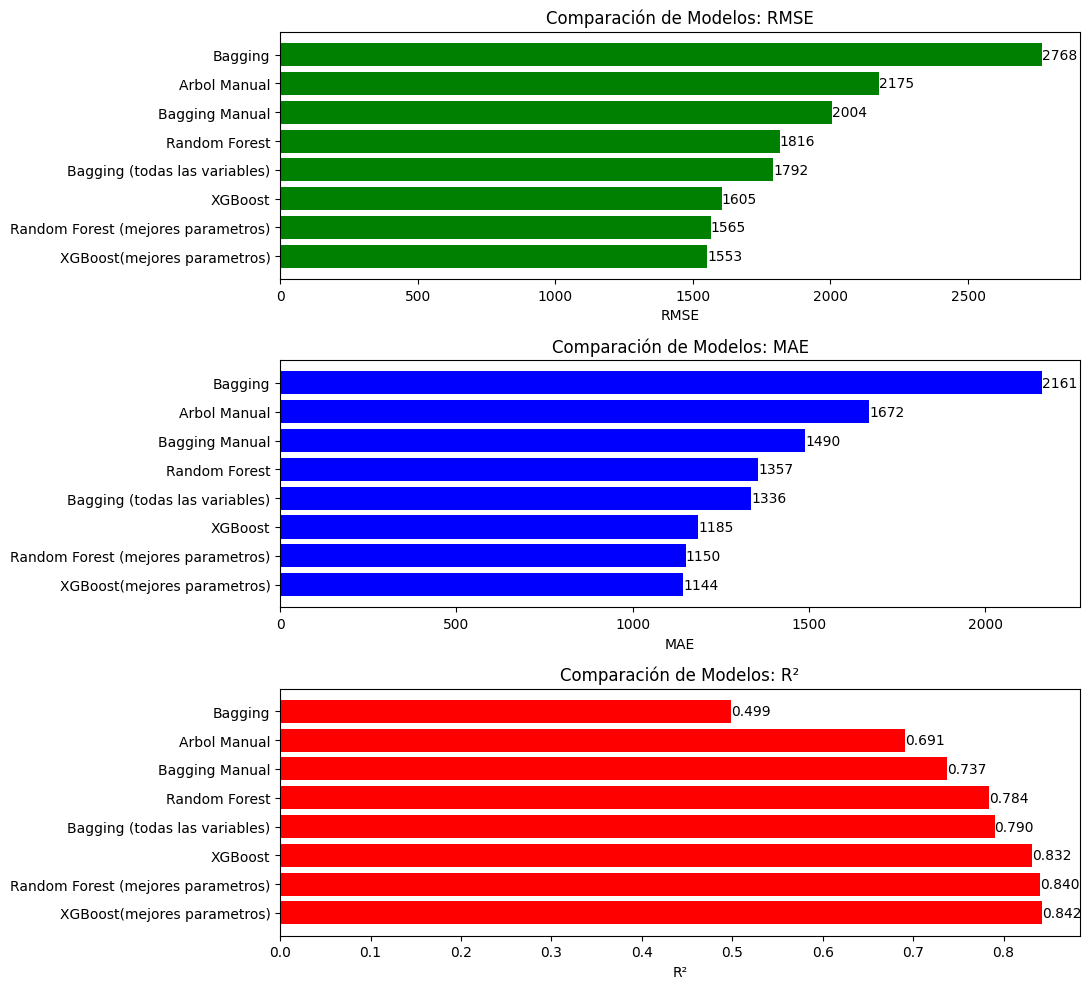

In [51]:
# Función para graficar las barras horizontales
def plot_comparison(ax, df, metric, color):
    ax.barh(df['Modelo'], df[metric], color=color)
    ax.set_xlabel(metric)
    ax.set_title(f'Comparación de Modelos: {metric}')
    for index, value in enumerate(df[metric]):
        if metric in ['RMSE', 'MAE']: # Ajustar el formato de los números 
            ax.text(value, index, f'{value:.0f}', va='center', ha='left', color='black')
        else:
            ax.text(value, index, f'{value:.3f}', va='center', ha='left', color='black')

df_comparacion_sorted_rmse = df_comparacion.sort_values('RMSE')
df_comparacion_sorted_mae = df_comparacion.sort_values('MAE')
df_comparacion_sorted_r2 = df_comparacion.sort_values('R²', ascending=False)
fig, axs = plt.subplots(3, 1, figsize=(11, 10))

plot_comparison(axs[0], df_comparacion_sorted_rmse, 'RMSE', 'green')
plot_comparison(axs[1], df_comparacion_sorted_mae, 'MAE', 'blue')
plot_comparison(axs[2], df_comparacion_sorted_r2, 'R²', 'red')

plt.tight_layout()
plt.show()

**Análisis**

En las tablas y gráficas, cuando no hay especificaciones adicionales, quiere decir que se utilizaron los valores predeterminados de la librería. Al analizar las métricas:

* **RMSE y MAE:**  
  - Los modelos de Random Forest y XGBoost, ajustados con sus mejores parámetros, tienen los errores más bajos. Esto refleja su capacidad para adaptarse mejor a los datos.  
  - Destaca que XGBoost con parámetros predeterminados logró un buen rendimiento. Esto sugiere que, incluso sin ajustes, es una herramienta robusta.  
  - Los modelos implementados manualmente (*Árbol Manual*, *Bagging Manual*) tienen errores más altos. Esto evidencia las ventajas de las librerías, que incluyen optimizaciones desarrolladas.  

* **R²:**  
  - Los modelos optimizados (*XGBoost* y *Random Forest*) explican hasta el 84% de la varianza, lo que indica un ajuste muy bueno.  
  - En contraste, los modelos manuales tienen una capacidad explicativa limitada. Esto refuerza la necesidad de no solo usar librerías, sino también ajustar sus parámetros.

* **Venajas XGBoost**
El modelo tiene una mejor precisión con respecto a random forest. Al calibrar sus hiperparámetros se pueden asegurar mejores resultados y controlar el aprendizaje. También sus mecanismos de de regularización le permiten disminuir el overfitting.

* **Desventajas de Random Forest:**
EL modelo de Random Forest tiene tendencia a sobreajustar si no se determinan bien sus parámetros `max_depth`, `max_features` y `n_estimators`. De igual manera, es menos flexible cuando se utilizan conjuntos de datos más grandes.

**Sobre los modelos de Bagging:**  
- El *Bagging con parámetros predeterminados* tuvo el peor desempeño (RMSE: 2175, R²: 0.499). Esto refleja la importancia de ajustar el modelo al paquete de datos trabajados, ya que ajustando un solo parámetro se logró llegar a buenas métricas (RMSE: 1792, R²: 0.790).
- El *Bagging Manual*, aunque supera la media de los modelos, aún está lejos de los modelos optimizados. Esto resalta que incluso con ajustes básicos, las librerías especializadas ofrecen ventajas técnicas difíciles de ejecutar manualmente.  

Es importante resaltar que para la optimización de los modelos se implementó técnicas de validación cruzada, lo cual es clave para que los resultados obtenidos logren ser replicados

**Referencias**
- Garcia, A. (2023). *Optimización de hiperparámetros de un clasificador de Machine Learning en Python*. https://panamahitek.com/optimizacion-de-hiperparametros-machine-learning/

- Amazon Web Services. (s.f.). *XGBoost hiperparámetros*. AWS Documentation. https://docs.aws.amazon.com/es_es/sagemaker/latest/dg/xgboost_hyperparameters.html

- Belcic, I., & Stryker, C. (2024). *¿Qué es el ajuste de hiperparámetros?* IBM. https://www.ibm.com/es-es/think/topics/hyperparameter-tuning

- XGBoost Developers. (2022). *XGBoost parameters*. https://xgboost.readthedocs.io/en/stable/parameter.html

- Datacamp. (2024). *Random Forest Classification with Scikit-Learn*. https://www.datacamp.com/tutorial/random-forests-